In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import collections


# Other Libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("C://Users/matth/Downloads/310_23498_compressed_creditcard.csv/creditcard.csv")

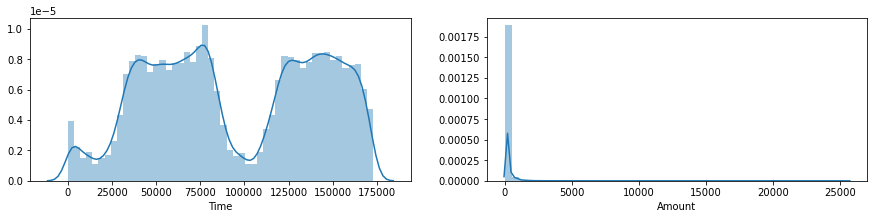

In [3]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.distplot(df.Time)
plt.subplot(1,2,2)
sns.distplot(df.Amount)

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler=RobustScaler()

df["scaled_time"]=scaler.fit_transform(df["Time"].values.reshape(-1,1))
df["scaled_amount"]=scaler.fit_transform(df["Amount"].values.reshape(-1,1))

In [5]:
df.drop(["Time","Amount"],axis=1,inplace=True)

In [6]:
small_df=df.sample(n=16000)
X=small_df.drop(["Class"],axis=1)
y=small_df["Class"]

In [7]:
#This cell is not needed if we are not over/undersampling. I'll try without over/under as the score becomes too high
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over=RandomOverSampler(sampling_strategy=0.5)
under=RandomUnderSampler(sampling_strategy=0.5)
#X,y=under.fit_resample(X,y)
#print(Counter(y))
X,y=over.fit_resample(X,y)
#print(Counter(y))
X.shape,y.shape,Counter(y)

((23953, 30), (23953,), Counter({0: 15969, 1: 7984}))

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)

In [9]:
model=lgb.LGBMClassifier()
default_params=model.get_params()
del default_params["n_estimators"]
cv_results=lgb.cv(default_params,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
print("Baseline AUC score without tuning is {:.5f}".format(cv_results['auc-mean'][-1]))
print("Baseline boosting rounds are {}".format(len(cv_results['auc-mean'])))

Baseline AUC score without tuning is 0.99999
Baseline boosting rounds are 135


In [10]:
model.n_estimators=len(cv_results['auc-mean'])
model.fit(X_train,y_train)
pred=model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred)

1.0

In [71]:
# I need a function that eats a parameter set and spits out a score
def objective(hyperparameters,iteration):
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters["n_estimators"]
    cv_results=lgb.cv(hyperparameters,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
    train_score=cv_results['auc-mean'][-1]
    estimators=len(cv_results['auc-mean'])
    hyperparameters['n_estimators']=estimators
    
    model=lgb.LGBMClassifier(**hyperparameters,random_state=42)
    model.fit(X_train,y_train)
    test_score=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    
    return [train_score,test_score, hyperparameters,iteration]

In [12]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [13]:
import random
random.seed(50)
boosting_type=random.sample(param_grid['boosting_type'],1)[0]
subsample=1.0 if boosting_type=="goss" else random.sample(param_grid['subsample'],1)[0]
print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


In [104]:
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(5)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(5)))

In [72]:
#I need a function that eats many sets of parameters and spits out every score (stored in a DataFrame),
#then chooses the best parameter set
import itertools

def grid_search(param_grid,max_eval=5):
    results=pd.DataFrame(columns=["train score","test score","params","iteration"],index=list(range(5)))
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        hyperparameters["subsample"]=1.0 if hyperparameters['boosting_type']=='goss' else hyperparameters['subsample']
        eval_results=objective(hyperparameters,i)
        results.loc[i,:]=eval_results
        i+=1
        if i>5:
            break
    results.sort_values("test score",ascending=False,inplace=True)
    results.reset_index(inplace=True)
    return results
        

In [73]:
new_params=grid_search(param_grid).loc[0,'params']

In [74]:
new_model=lgb.LGBMClassifier(param_grid=new_params,random_state=42)
cv_results=lgb.cv(new_params,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
cv_results['auc-mean'][-1]

0.9999493079242884

In [75]:
new_model=lgb.LGBMClassifier(**new_params)
new_model.fit(X_train,y_train)
X_full,y_full=df.drop("Class",axis=1),df["Class"]
pred=new_model.predict_proba(X_full)[:,1]

roc_auc_score(y_full,pred)

0.9520846138679631

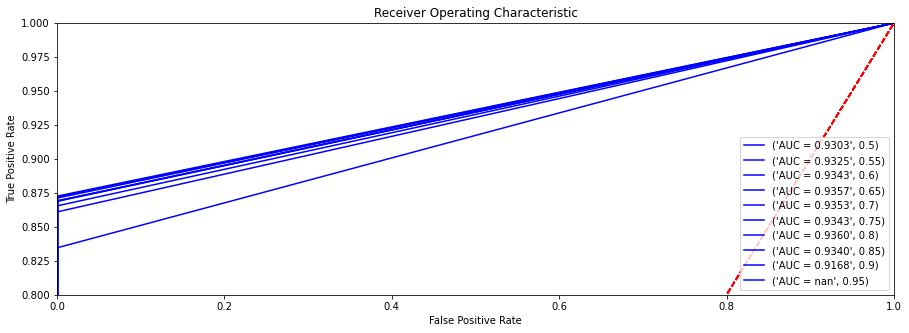

0.9500000000000004 0.5


In [78]:
limit=np.arange(0.5,1,0.05)
plt.figure(figsize=(15,5))
plt.title('Receiver Operating Characteristic')


for x in limit:
    rounded_pred=[1 if i>=x else 0 for i in pred]
    fpr, tpr, threshold=metrics.roc_curve(rounded_pred,y_full)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = ('AUC = %0.4f' % roc_auc,round(x,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0.8, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()
    
print(x,roc_auc_score(y_full,rounded_pred))

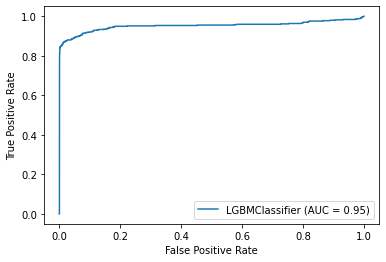

In [77]:
metrics.plot_roc_curve(new_model, X_full, y_full)

In [124]:
1-len(df[df["Class"]==1])/len(df)

0.9982725143693799